Text generation can be done through simply predicting the next most likely word, given an input sequence. This can be done over and over by feeding the original input sequence, plus the newly predicted end word, as the next input sequence to the model. As such, the full output generated from a very short original input can effectively go on however long you want it to be.

The only real change to the network here is the output layer will now be equivalent to a node per each possible new word to generate - so, if you have 1,000 possible words in your corpus, you’d have an output array of length 1,000. You’ll also need to change the loss function from binary cross-entropy to categorical cross entropy - before, we had only a 0 or 1 as output, now there are potentially thousands of output “classes” (each possible word).

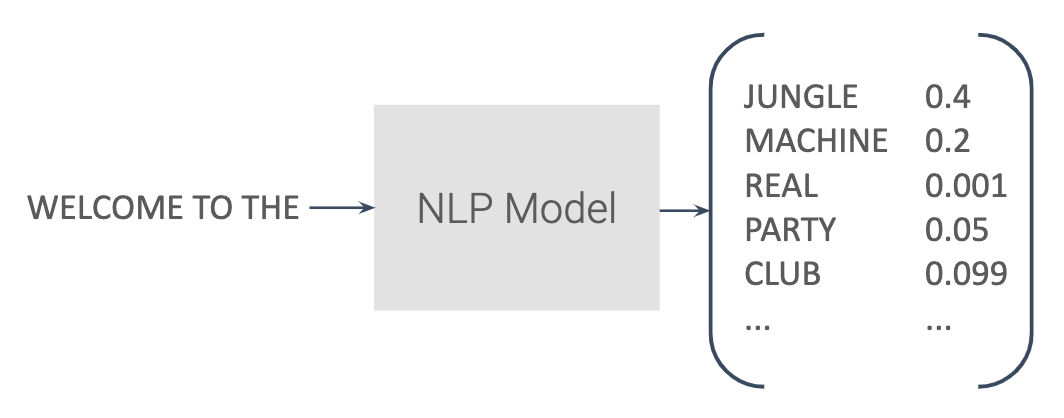

**For text generation:**
- Predict the next word in the sequence
- Feed old input plus a new output word as the next input
- Make the output a one-hot encoded label over entire corpus of desired text outputs
- Utilize categorical cross entropy loss function as the output will be multi-class

The text generation model has the probabilities for all the words that can be the output and the word with the max probability is the one that completes the sequence.

In terms of modelling, there's not much of a difference in the network architecture except for changing the number of nodes in the output layer and changing the loss function.

The more obvious changes come in working with the input and output data. The input data takes chunks of sequences and just splits off the final word as its label.

So, if we had the sentence “I went to the beach with my dog”, and we had a max input length of five words, we’d get:

- Input: I went to the beach

- Label: with

Now, that’s not the only sequence that will come from the sentence! We would also get:

- Input: went to the beach with

- Label: my

And:

- Input: to the beach with my

- Label: dog

That’s how the N-Grams used in the pre-processing work - a single input sequence might actually become a series of sequences and labels.

#Simple Text Generation Model

In [ ]:
#Import TensorFlow and related functions
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Other imports for processing data
import string
import numpy as np
import pandas as pd

In [ ]:
#Get Dataset
!wget --no-check-certificate \
    https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 \
    -O /tmp/songdata.csv

--2024-02-25 14:41:49--  https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving drive.google.com (drive.google.com)... 142.250.65.110, 2607:f8b0:4025:804::200e
Connecting to drive.google.com (drive.google.com)|142.250.65.110|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 [following]
--2024-02-25 14:41:49--  https://drive.usercontent.google.com/download?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.217.12.1, 2607:f8b0:4025:815::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.217.12.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72436445 (69M) [application/octet-stream]
Saving to: ‘/tmp/songdata.csv’

/tmp/songdata.csv   100%[===================>]  69.08M  73.5MB/s    in 0.9s    

2024-02-25 14:41:54 (73.5 MB/s) - ‘/tmp/s

In [ ]:
# Define preprocessing functions
def tokenize_corpus(corpus, num_words=-1):
  # Fit a Tokenizer on the corpus
  if num_words > -1:
    tokenizer = Tokenizer(num_words=num_words)
  else:
    tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus)
  return tokenizer

def create_lyrics_corpus(dataset, field):
  # Remove all other punctuation
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')
  # Make it lowercase
  dataset[field] = dataset[field].str.lower()
  # Make it one long string to split by line
  lyrics = dataset[field].str.cat()
  corpus = lyrics.split('\n')
  # Remove any trailing whitespace
  for l in range(len(corpus)):
    corpus[l] = corpus[l].rstrip()
  # Remove any empty lines
  corpus = [l for l in corpus if l != '']

  return corpus

In [ ]:
# Read the dataset from csv - just first 10 songs for now
dataset = pd.read_csv('/tmp/songdata.csv', dtype=str)[:10]
# Create the corpus using the 'text' column containing lyrics
corpus = create_lyrics_corpus(dataset, 'text')
# Tokenize the corpus
tokenizer = tokenize_corpus(corpus)

total_words = len(tokenizer.word_index) + 1

print(tokenizer.word_index)
print(total_words)

{'you': 1, 'i': 2, 'and': 3, 'a': 4, 'me': 5, 'the': 6, 'is': 7, 'my': 8, 'to': 9, 'ma': 10, 'it': 11, 'of': 12, 'im': 13, 'your': 14, 'love': 15, 'so': 16, 'as': 17, 'that': 18, 'in': 19, 'andante': 20, 'boomaboomerang': 21, 'make': 22, 'on': 23, 'oh': 24, 'for': 25, 'but': 26, 'new': 27, 'bang': 28, 'its': 29, 'be': 30, 'like': 31, 'know': 32, 'now': 33, 'how': 34, 'could': 35, 'youre': 36, 'sing': 37, 'never': 38, 'no': 39, 'chiquitita': 40, 'can': 41, 'we': 42, 'song': 43, 'had': 44, 'good': 45, 'youll': 46, 'she': 47, 'just': 48, 'girl': 49, 'again': 50, 'will': 51, 'take': 52, 'please': 53, 'let': 54, 'am': 55, 'eyes': 56, 'was': 57, 'always': 58, 'cassandra': 59, 'blue': 60, 'time': 61, 'dont': 62, 'were': 63, 'return': 64, 'once': 65, 'then': 66, 'sorry': 67, 'cryin': 68, 'over': 69, 'feel': 70, 'ever': 71, 'believe': 72, 'what': 73, 'do': 74, 'go': 75, 'all': 76, 'out': 77, 'think': 78, 'every': 79, 'leave': 80, 'look': 81, 'at': 82, 'way': 83, 'one': 84, 'music': 85, 'down': 

<ipython-input-3-7c033cb6d04d>:13: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')


After preprocessing, we next need to create sequences and labels. Creating the sequences themselves is similar to before with texts_to_sequences, but also including the use of N-Grams; creating the labels will now utilize those sequences as well as utilize one-hot encoding over all potential output words.

In [ ]:
#Create Sequences and Labels
sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		sequences.append(n_gram_sequence)

# Pad sequences for equal input length
max_sequence_len = max([len(seq) for seq in sequences])
sequences = np.array(pad_sequences(sequences, maxlen=max_sequence_len, padding='pre'))

# Split sequences between the "input" sequence and "output" predicted word
input_sequences, labels = sequences[:,:-1], sequences[:,-1]
# One-hot encode the labels
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [ ]:
# Check out how some of our data is being stored
# The Tokenizer has just a single index per word
print(tokenizer.word_index['know'])
print(tokenizer.word_index['feeling'])
# Input sequences will have multiple indexes
print(input_sequences[5])
print(input_sequences[6])
# And the one hot labels will be as long as the full spread of tokenized words
print(one_hot_labels[5])
print(one_hot_labels[6])

32
97
[  0   0   0   0   0   0   0   0   0   0   0   0   0  81  82 142 197  29
   4]
[  0   0   0   0   0   0   0   0   0   0   0   0  81  82 142 197  29   4
 287]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

Building an RNN to train our text generation model will be very similar to the sentiment models you've built previously. The only real change necessary is to make sure to use Categorical instead of Binary Cross Entropy as the loss function - we could use Binary before since the sentiment was only 0 or 1, but now there are hundreds of categories.

From there, we should also consider using more epochs than before, as text generation can take a little longer to converge than sentiment analysis, and we aren't working with all that much data yet. I'll set it at 200 epochs here since we're only use part of the dataset, and training will tail off quite a bit over that many epochs.

In [ ]:
# Build the model and train it
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(input_sequences, one_hot_labels, epochs=200, verbose=1)

Epoch 1/200
62/62 [==============================] - 5s 16ms/step - loss: 5.9781 - accuracy: 0.0192
Epoch 2/200
62/62 [==============================] - 1s 19ms/step - loss: 5.4348 - accuracy: 0.0333
Epoch 3/200
62/62 [==============================] - 1s 21ms/step - loss: 5.3673 - accuracy: 0.0399
Epoch 4/200
62/62 [==============================] - 2s 32ms/step - loss: 5.3104 - accuracy: 0.0454
Epoch 5/200
62/62 [==============================] - 2s 30ms/step - loss: 5.2397 - accuracy: 0.0404
Epoch 6/200
62/62 [==============================] - 1s 15ms/step - loss: 5.1759 - accuracy: 0.0444
Epoch 7/200
62/62 [==============================] - 1s 16ms/step - loss: 5.1164 - accuracy: 0.0429
Epoch 8/200
62/62 [==============================] - 1s 19ms/step - loss: 5.0578 - accuracy: 0.0378
Epoch 9/200
62/62 [==============================] - 1s 18ms/step - loss: 4.9893 - accuracy: 0.0515
Epoch 10/200
62/62 [==============================] - 1s 16ms/step - loss: 4.9138 - accuracy: 0.0494

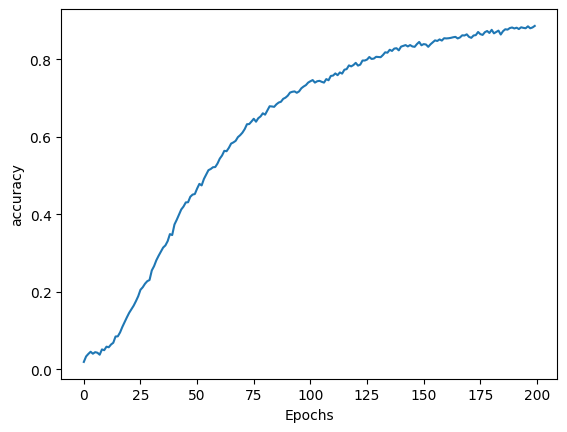

In [ ]:
# Visualize training performance
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')

It's finally time to generate some new lyrics from the trained model, and see what we get. To do so, we'll provide some "seed text", or an input sequence for the model to start with. We'll also decide just how long of an output sequence we want - this could essentially be infinite, as the input plus the previous output will be continuously fed in for a new output word (at least up to our max sequence length).

In [ ]:
#Generate new lyrics!
seed_text = "im feeling chills"
next_words = 100

for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = np.argmax(model.predict(token_list), axis=-1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

1/1 [==============================] - 0s 24ms/step
im feeling chills me girl she to fight so fine fine fine see do do what could i do mine mine mine mine sender music hardly need cassandra bang a boomaboomerang is love in return to do what could here again cause i did sender am song chiquitita do of wrong truth do i do mine mine mine again i sender music hardly need boomaboomerang you had think crazy sun song song question new bone bone body sucker music music bang as new song chiquitita you had didnt notion do mine wrong fingers sleep shoulder did start start start morning dont wrong wrong


#Optimizing Models

**Options:**
1. Using More Data for Training
2. Improving Memory and Output size constraints
3. Using only top-k most common words
4. Adding to/subtracting from layer sizes or embedding dimensions
5. Using np.random.choice(opens in a new tab) with the probabilities for more variance in predicted outputs
6. Understanding your data well

Now we've seen a model trained on just a small sample of songs, and how this often leads to repetition as you get further along in trying to generate new text. Let's switch to using the 250 songs instead, and see if our output improves. This will actually be nearly 10K lines of lyrics, which should be sufficient.

Note that we won't use the full dataset here as it will take up quite a bit of RAM and processing time, but you're welcome to try doing so on your own later. If interested, you'll likely want to use only some of the more common words for the Tokenizer, which will help shrink processing time and memory needed (or else you'd have an output array hundreds of thousands of words long).

In [ ]:
# Read the dataset from csv - this time with 250 songs
dataset = pd.read_csv('/tmp/songdata.csv', dtype=str)[:250]
# Create the corpus using the 'text' column containing lyrics
corpus = create_lyrics_corpus(dataset, 'text')
# Tokenize the corpus
tokenizer = tokenize_corpus(corpus, num_words=2000)
total_words = tokenizer.num_words

# There should be a lot more words now
print(total_words)

<ipython-input-3-7c033cb6d04d>:13: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')


2000


In [ ]:
#Create sequences and labels
sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		sequences.append(n_gram_sequence)

# Pad sequences for equal input length
max_sequence_len = max([len(seq) for seq in sequences])
sequences = np.array(pad_sequences(sequences, maxlen=max_sequence_len, padding='pre'))

# Split sequences between the "input" sequence and "output" predicted word
input_sequences, labels = sequences[:,:-1], sequences[:,-1]
# One-hot encode the labels
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [ ]:
# Train a (Better) Text Generation Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(input_sequences, one_hot_labels, epochs=100, verbose=1)

Epoch 1/100
1480/1480 [==============================] - 40s 24ms/step - loss: 5.9757 - accuracy: 0.0464
Epoch 2/100
1480/1480 [==============================] - 34s 23ms/step - loss: 5.6523 - accuracy: 0.0531
Epoch 3/100
1480/1480 [==============================] - 31s 21ms/step - loss: 5.4526 - accuracy: 0.0723
Epoch 4/100
1480/1480 [==============================] - 30s 20ms/step - loss: 5.2684 - accuracy: 0.1039
Epoch 5/100
1480/1480 [==============================] - 29s 20ms/step - loss: 5.0971 - accuracy: 0.1227
Epoch 6/100
1480/1480 [==============================] - 30s 20ms/step - loss: 4.9510 - accuracy: 0.1368
Epoch 7/100
1480/1480 [==============================] - 31s 21ms/step - loss: 4.8179 - accuracy: 0.1474
Epoch 8/100
1480/1480 [==============================] - 29s 20ms/step - loss: 4.6867 - accuracy: 0.1609
Epoch 9/100
1480/1480 [==============================] - 30s 20ms/step - loss: 4.5600 - accuracy: 0.1735
Epoch 10/100
1480/1480 [==============================]

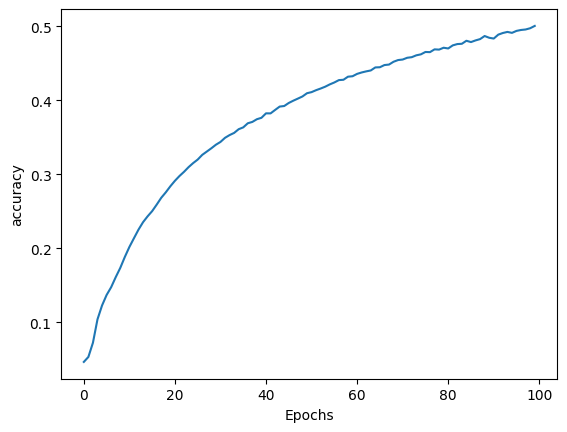

In [ ]:
# Visualize training performance
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')

In [ ]:
# Generate Text

seed_text = "im feeling chills"
next_words = 100

for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = np.argmax(model.predict(token_list), axis=-1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

1/1 [==============================] - 0s 25ms/step
im feeling chills it easy to it against the rest of the sound world learn to take it down gotta have room blown nine magic have a while it never shines gotta put gotta get understand think it weave make make noise in give give anything darling i got stars to go blown a little game house house gonna never mean to know fuckin tall chance on nine point earth get but in miss last check crowd laughed and let it up to you take it all when it used to see the things that sunny side affair true day come told return


In running the above, you may notice that the same seed text will generate similar outputs. This is because the code is currently always choosing the top predicted class as the next word. What if you wanted more variance in the output?

Switching from model.predict_classes to model.predict_proba will get us all of the class probabilities. We can combine this with np.random.choice to select a given predicted output based on a probability, thereby giving a bit more randomness to our outputs.

In [ ]:
#Vary the outputs
# Test the method with just the first word after the seed text
seed_text = "im feeling chills"
next_words = 100

token_list = tokenizer.texts_to_sequences([seed_text])[0]
token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
predicted_probs = model.predict(token_list)[0]
predicted = np.random.choice([x for x in range(len(predicted_probs))],
                             p=predicted_probs)
# Running this cell multiple times should get you some variance in output
print(predicted)

1/1 [==============================] - 0s 25ms/step
13


In [ ]:
# Use this process for the full output generation
seed_text = "im feeling chills"
next_words = 100

for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  predicted_probs = model.predict(token_list)[0]
  predicted = np.random.choice([x for x in range(len(predicted_probs))],
                               p=predicted_probs)
  output_word = ""
  for word, index in tokenizer.word_index.items():
    if index == predicted:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

1/1 [==============================] - 0s 27ms/step
im feeling chills your pirouette you learn to wait to show i ill sound longer look for each other shoes blown cryin on broken midnight misfortune tail wish mm lump stars bone dreadful fuckin melody missing cryin toys decision chance gives eight you dont get you think on me hold me we aint got no place forever is gotta go escape pick for you dont throw her hands a marionette mustve blowing down comin forever learned ceiling sounds honey fear catch catch catch catch uh damn song wish ba time breakfast song bee suzyhangaround suzyhangaround wish beg beg huh feelings twist situation sincere
